<div class="alert alert-block alert-success">
    <b>ARTIFICIAL INTELLIGENCE (E016350A)</b> <br>
ALEKSANDRA PIZURICA <br>
GHENT UNIVERSITY <br>
AY 2024/2025 <br>
Assistant: Nicolas Vercheval
</div>

## Lab assignment: Imbalanced Data


The `framingham.csv` file contains medical data from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts, who participated in cardiovascular disease prevention trials. The classification goal is to predict whether the patient has a 10-year risk of future coronary heart disease (CHD). The set contains 15 attributes that combine the sociological and medical characteristics of the respondents, such as age, gender, body mass index, blood sugar concentration and others. Each attribute is a potential risk factor. The goal is to make a classifier that can predict the occurrence of heart problems based on these data. Information on the occurrence of subjects' heart problems was recorded at the level of the TenYearCHD attribute.

### Exercise

In this notebook, we see different techniques for handling imbalanced datasets:
- stratifying the dataset
- choosing a loss that gives more weight to the minority class
- data undersampling and oversampling

Your task is to follow the steps below and answer the questions.

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix

In [3]:
data = pd.read_csv(os.path.join(os.pardir, 'data', 'framingham.csv'))
target = 'TenYearCHD'
pd.set_option('display.precision', 2)
answers = {}

##### Problem formulation
In a real modelling application, we must carefully analyze the goal of our problem, its scope and the possible implications that our modelling may entail. The success criteria should reflect the context and the overall goal. We should formulate hypotheses that rely on causation rather than correlation whenever possible and be careful when using sensitive information or avoid using it entirely. 

**Step 1:** Visualize the first and last three rows of the data frame and show the information about the attributes using its `info` method. 

In [4]:
data.head(3)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0


In [5]:
data.tail(3)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0
4237,0,52,2.0,0,0.0,0.0,0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


**Question 1:** Which attribute does not seem relevant to the prediction? Write its column name as the answer.

In [7]:
answers[1] = 'education'

##### Categorical variables
A categorical variable is a variable that expresses a quality rather than a quantity. They can take a limited number of values, each having a separate meaning. Often, these values are stored as strings; other times, they are stored using integers and a lookup table.
In a dataset of houses, an example of a categorical attribute is whether the house is an apartment, a villa, or something different.

**Step 2:** Remove the attribute that should not be used for this task. We see that there are columns with null values. Drop all rows that contain at least one missing value. Remove duplicates if there are any. Reset the index of the dropped rows. Check again the shape of your data and encapsulate it in a new data frame called `data_cleaned`. 

In [8]:
data.dropna(how='any', axis=0, inplace=True)
data_cleaned = data.drop('education', axis=1)
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3656 entries, 0 to 4237
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3656 non-null   int64  
 1   age              3656 non-null   int64  
 2   currentSmoker    3656 non-null   int64  
 3   cigsPerDay       3656 non-null   float64
 4   BPMeds           3656 non-null   float64
 5   prevalentStroke  3656 non-null   int64  
 6   prevalentHyp     3656 non-null   int64  
 7   diabetes         3656 non-null   int64  
 8   totChol          3656 non-null   float64
 9   sysBP            3656 non-null   float64
 10  diaBP            3656 non-null   float64
 11  BMI              3656 non-null   float64
 12  heartRate        3656 non-null   float64
 13  glucose          3656 non-null   float64
 14  TenYearCHD       3656 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 457.0 KB


**Question 2:** Which of the following list corresponds to the categorical or binary attributes of `data_cleaned`? 
1) male, age, currentSmoker, prevalentStroke, prevalentHyp, diabetes, TenYearCHD
2) male, currentSmoker, BPMeds, prevalentStroke, prevalentHyp, diabetes, TenYearCHD
3) male, age, BPMeds, cigsPerDay, currentSmoker, prevalentStroke, prevalentHyp, diabetes, TenYearCHD
4) male, age, BPMeds, cigsPerDay, currentSmoker, prevalentStroke, prevalentHyp, diabetes, totChol, sysBP, diaBP, TenYearCHD, glucose, heartRate

Write the number of the correct answer below.

In [9]:
answers[2] = 4

##### Stratification
Stratifying a dataset by one variable means that you want to separate the dataset into multiple subsets in a way that the distribution of the variable is similar across all the subsets. A typical example is partitioning a dataset into a training and test (or validation) dataset. Without stratification, one imbalanced class may be entirely missing from one dataset.

**Step 3** 
Imbalanced data refers to datasets where the target class has an uneven distribution of observations, i.e., one class label has a very high number of observations and the other has a very low number of observations.
- Is there a class imbalance in our case? Has the dataset been split evenly by class?
- Visualize the imbalance in the binary classes by using the `countplot` function inside of `seaborn`.

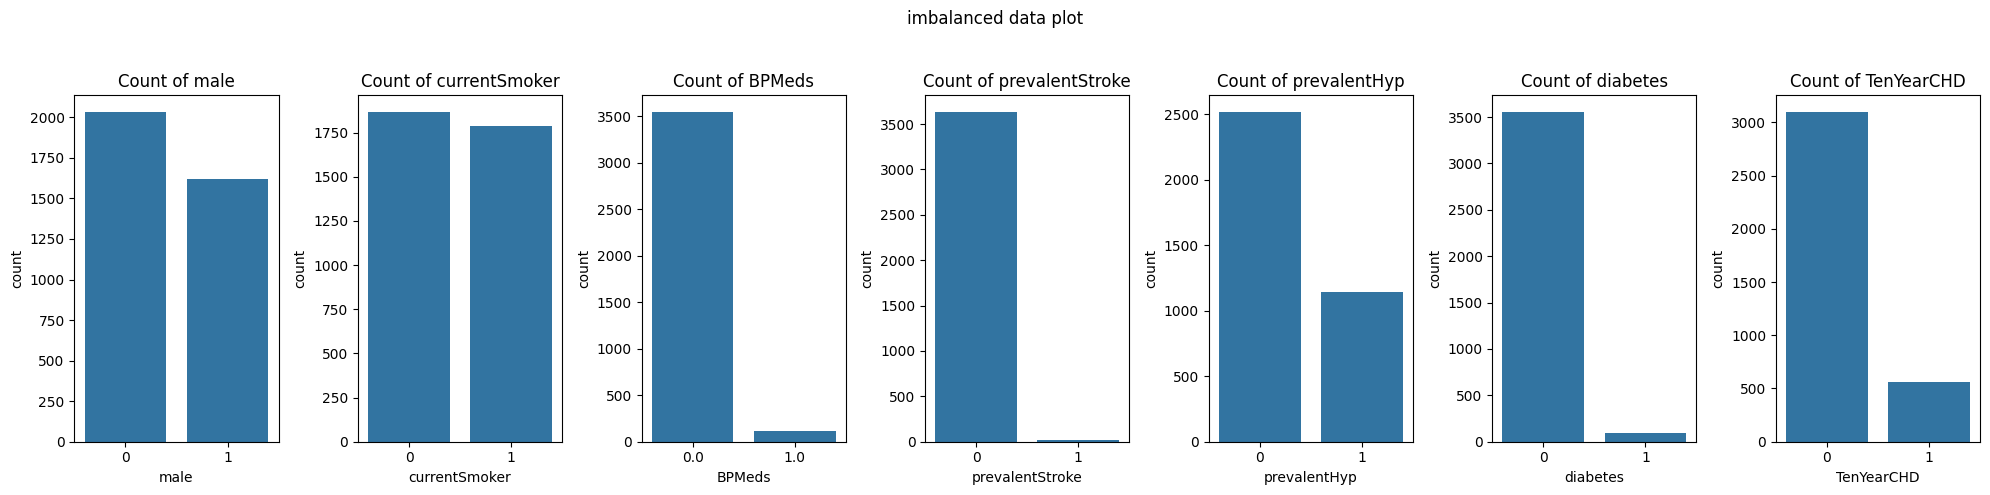

In [10]:
columns = ['male', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']

fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
fig.suptitle("imbalanced data plot")

for col, ax in zip(columns, axes):
    sns.countplot(x=col, data=data_cleaned, ax=ax)
    ax.set_title(f"Count of {col}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Question 3:** This dataset presents class imbalances in many binary variables. If we don't take precautions, any of these variables may not be well represented in either the training or the test dataset. Consider the task at hand. The imbalance of which variable is particularly concerning? In the next step, you will use that variable to stratify the training and test dataset.
Write a string with the name of that variable as it is written in the DataFrame.

In [11]:
answers[3] = 'prevalentStroke'

**Step 4:** Divide the data into a training set and a test set in the ratio $4:1$ and use the opportune variable for stratification. Set the `random_state` parameter to $5$.
Create two new data frames,  `training_data` and `test_data`, containing the two splits.

In [12]:
training_data, test_data = model_selection.train_test_split(data_cleaned, test_size=0.2, random_state=5, stratify=data_cleaned['prevalentStroke'])

In [13]:
training_data.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
1928,0,42,1,20.0,0.0,0,0,0,193.0,129.0,91.5,27.78,95.0,74.0,0
3646,0,37,1,15.0,0.0,0,0,0,275.0,118.0,71.0,23.10,64.0,95.0,0
1114,1,53,1,43.0,0.0,0,0,0,220.0,119.0,75.0,26.28,82.0,67.0,0
1438,1,54,0,0.0,0.0,0,0,0,254.0,136.5,83.0,20.55,88.0,95.0,0
2071,0,54,0,0.0,0.0,0,0,0,288.0,124.0,77.0,29.88,79.0,92.0,0


**Question 4:** What number did you insert to have the correct ratio as parameter for `test_size` in `model_selection.train_test_split`?

In [14]:
answers[4] = 0.2

**Step 5:** Check which features are correlated with each other and with the outcome variable `TenYearCHD`. Create a `seaborn` correlation heatmap. Do not use the test dataset.

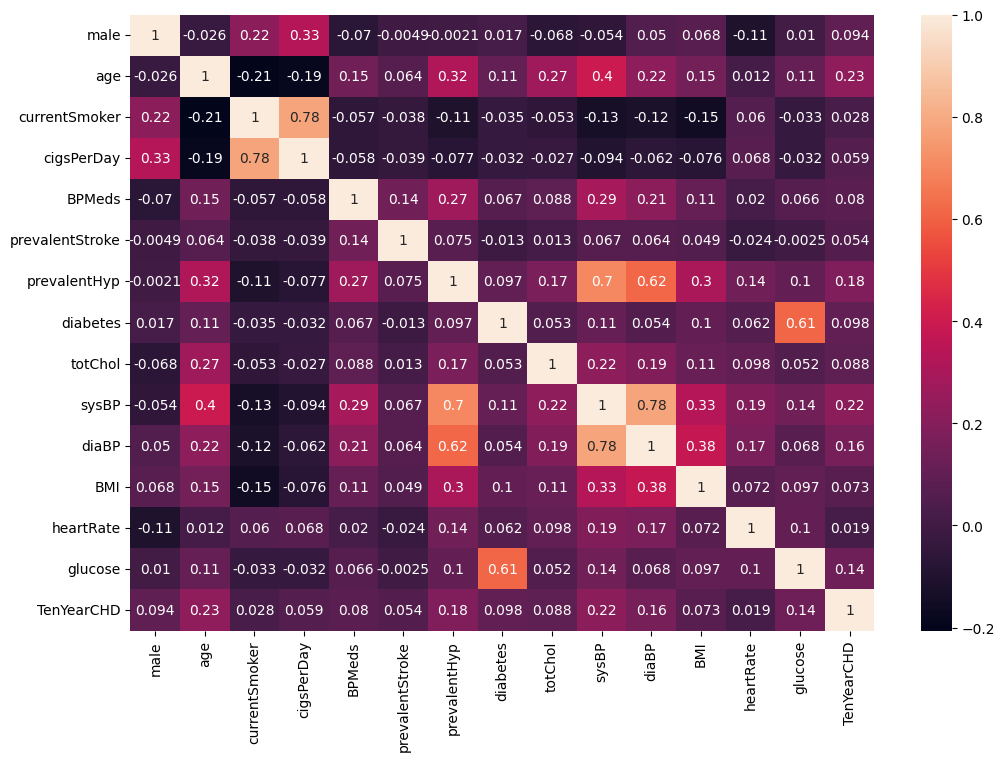

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(training_data.corr(numeric_only=True), annot=True)
plt.show()

**Question 5:** 

The `Heatmap` shows that some features are highly correlated. See which two attributes have the highest correlation and drop the one that is less correlated to the target variable. Write its name in the answer.

In [16]:

answers[5] = 'currentSmoker'

**Step 6:** Drop the previous variable from the train and testing dataset. Identify the features with the most importance for the outcome variable `TenYearCHD`. Apply the `SelectKBest` class to extract the most impactful features for the target variable. For the moment, keep all the attributes. Visualize the features by their score (attribute `scores_` of the trained selector) using `barplot`. 

In [17]:
training_data = training_data.drop('currentSmoker', axis=1)
test_data = test_data.drop('currentSmoker', axis=1)

In [18]:
# seperate feature from target
X = training_data.drop(columns=['TenYearCHD'])
y = training_data['TenYearCHD']

selector = SelectKBest(k='all')
selector.fit(X, y)

feature_scores = selector.scores_
feature_names = X.columns

score_data = pd.DataFrame({'Feature': feature_names, 'Scores': feature_scores})

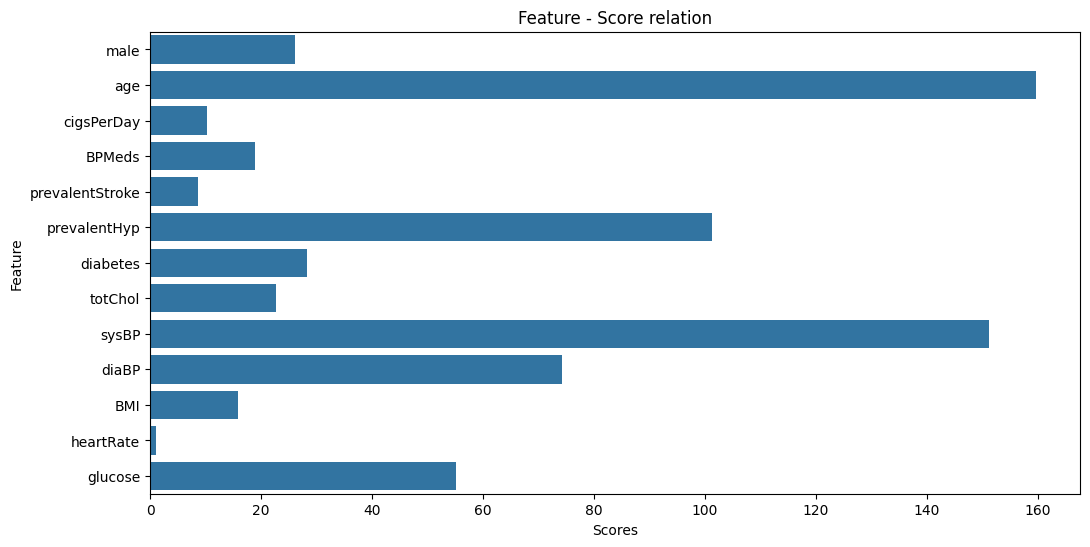

In [19]:
plt.figure(figsize=(12,6))
sns.barplot(x='Scores', y='Feature', data=score_data)
plt.title("Feature - Score relation")
plt.show()

**Question 6**:
How many predictive features would you keep? Use the graph in **Step 6** to guide your choice.

In [20]:
# after calculating the median(= 26,2) we take this as threshold
answers[6] = 7

**Step 7:** 
Keep the most predictive variables according to your previous answer.
Rescaling the feature is always a good practice. Use the `MinMaxScaler` from `sklearn`. Call the two new data frames named `training_data_scaled` and `test_data_scaled` with the selected features. Note that they should also contain the target variable! 

In [21]:
training_data = training_data.drop(columns=['heartRate', 'prevalentStroke', 'cigsPerDay', 'BMI', 'BPMeds', 'totChol'])
test_data = test_data.drop(columns=['heartRate', 'prevalentStroke', 'cigsPerDay', 'BMI', 'BPMeds', 'totChol'])

In [22]:
selected_features = ['male', 'age', 'prevalentHyp', 'diabetes', 'sysBP', 'diaBP', 'glucose']

X_train = training_data.drop(columns=['TenYearCHD'])
y_train = training_data['TenYearCHD']
X_test = test_data.drop(columns=['TenYearCHD'])
y_test = test_data['TenYearCHD']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

training_data_scaled = pd.DataFrame(X_train_scaled, columns=selected_features)
training_data_scaled['TenYearCHD'] = y_train.values

test_data_scaled = pd.DataFrame(X_test_scaled, columns=selected_features)
test_data_scaled['TenYearCHD'] = y_test.values

In [23]:
print("Scaled Training Data:")
print(training_data_scaled.head())
print("\nScaled Test Data:")
print(test_data_scaled.head())

Scaled Training Data:
   male   age  prevalentHyp  diabetes  sysBP  diaBP  glucose  TenYearCHD
0   0.0  0.26           0.0       0.0   0.22   0.47     0.10           0
1   0.0  0.13           0.0       0.0   0.16   0.25     0.16           0
2   1.0  0.55           0.0       0.0   0.17   0.29     0.08           0
3   1.0  0.58           0.0       0.0   0.25   0.38     0.16           0
4   0.0  0.58           0.0       0.0   0.19   0.32     0.15           0

Scaled Test Data:
   male   age  prevalentHyp  diabetes  sysBP  diaBP  glucose  TenYearCHD
0   0.0  0.68           0.0       0.0   0.30   0.48     0.12           1
1   1.0  0.24           0.0       0.0   0.22   0.48     0.18           0
2   0.0  0.50           0.0       0.0   0.14   0.40     0.12           0
3   0.0  0.37           0.0       0.0   0.08   0.20     0.07           0
4   0.0  0.39           0.0       0.0   0.19   0.30     0.08           0


**Question 7**:
MinMaxScaler uses the minimum and the maximum values in each of the columns of the fitted data frame. In the previous step, which data frame did you fit the scaler to rescale the test dataset?
Options:
1) The training dataset to prevent data leakage.
2) The test dataset itself to make sure it is always in the right range.
3) The whole dataset to have more reliable statistics.
4) You did not rescale the test dataset.

Answer with the number corresponding to the correct answer.

In [24]:
answers[7]= 1

##### Confusion matrix and F1 score
When we do binary classification, we often call the samples associated with class $1$ as positives and those associated with class $0$ as negatives. Our model predicts whether a sample is positive or negative. If our model is correct, we have true positives (TP) and true negatives (TN). Otherwise, we have false positives (FP) and false negatives (FN).

We can write those four numbers in a matrix, called the confusion metrics, that has the following form:
$$
\begin{array}{c|cc}
 &\text{Actual Positive (P)} & \text{Actual Negative (N)} \\
\hline
\text{Predicted Positive (P)} & \text{True Positives (TP)} &  \text{False Positives (FP)}\\
\text{Predicted Negative (N)} & \text{False Negatives (FN)} & \text{True Negatives (TN)}\\
\end{array}
$$

Note that it is possible to extend the confusion matrix to a multiclass setup.

Often, when the positive cases are critical (e.g. in medicine), we speak of precision and recall:
\begin{align*}
\text{Precision} &= \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} \\
\text{Recall} &= \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
\end{align*}

Another common metric is the F1 score, which balances the metrics above.
$$\text{F1 score} = \frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

**Step 8:** Create a `LogisticRegression` model and call it `logistic`. Train it on the data prepared in the previous step and test it on the test dataset.  Show the test accuracy and the F1 score. Then, plot the confusion matrix.

In [25]:
X_train = training_data_scaled.drop(columns=['TenYearCHD'])
y_train = training_data_scaled['TenYearCHD']
X_test = test_data_scaled.drop(columns=['TenYearCHD'])
y_test = test_data_scaled['TenYearCHD']

# get model
logistic = linear_model.LogisticRegression()

# train model
logistic.fit(X_train, y_train)

predictions = logistic.predict(X_test)
accuracy = (predictions == y_test).sum() / len(y_test)
F1 = metrics.f1_score(y_true=y_test, y_pred=predictions)

print(f"The accuracy is {100 * accuracy:.2f}%.")
print(f"the f1 score is {F1}")

The accuracy is 85.38%.
the f1 score is 0.01834862385321101


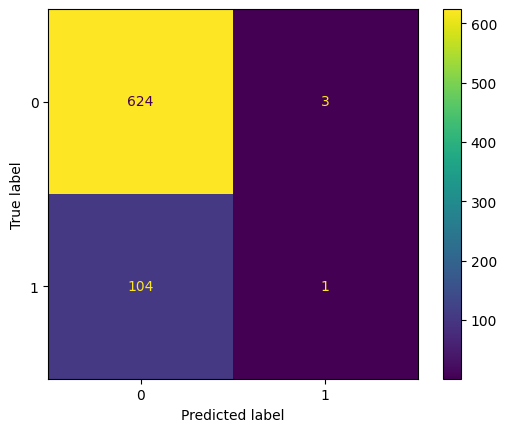

In [26]:
cm = confusion_matrix(y_test, predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

**Question 8:** How does the model perform? Choose between the following assessments.

1) The model works well because it has a high accuracy.
2) The model works well because almost all people who are not at risk are predicted correctly.
3) The model works poorly because the false negatives are very high.
4) It depends on the application. In the context of preventive medicine, it works poorly.

In [27]:
answers[8] = 3

##### Weighted logistic regression
Logistic regression treats each class in the same way. In some applications, we want to associate a higher cost when incorrectly predicting 
one of the classes. The `scikit-learn` library (as well as many others) allows us to accomplish that using the logistic regression model. It modifies the model update using the weighted average of each sample's loss.

**Step 9:**
Train a second logistic regression model using $1$ and $4$ as weights for the classes $0$ and $1$. Call it `weighted_logistic` and show the test metrics as in the previous step.

In [28]:
weighted_logistic = linear_model.LogisticRegression(class_weight={0: 1, 1: 4})

weighted_logistic.fit(X_train, y_train)

weighted_predictions = weighted_logistic.predict(X_test)
weighted_accuracy = (weighted_predictions == y_test).sum() / len(y_test)
weigted_F1 = metrics.f1_score(y_true=y_test, y_pred=weighted_predictions)

print(f"The accuracy is {100 * weighted_accuracy:.2f}%.")
print(f"the f1 score is {weigted_F1}")

The accuracy is 75.96%.
the f1 score is 0.38028169014084506


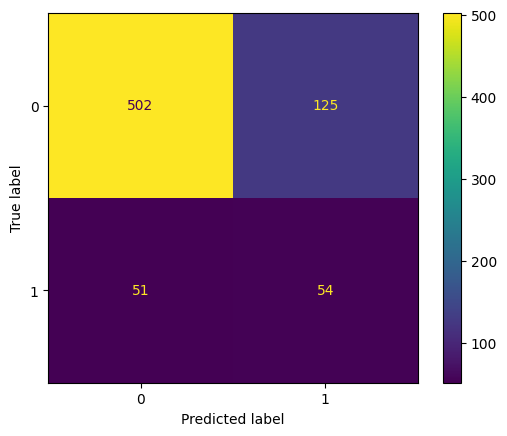

In [29]:
cm = confusion_matrix(y_test, weighted_predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

**Question 9:** 
A different way of giving more weight to the minority class is with augmentation and resampling techniques. In the next step, you are going to implement such a technique. Which transformation of the data would you perform?
1) Augmentation and undersampling on the training and the test dataset separately to ensure no data leakage.
2) Augmentation only on the training dataset but undersampling both datasets.
3) You wouldn't modify the test dataset.
4) It depends on what gives you the best results.


In [30]:
answers[9] = 2

**Step 10:** Often, we combine both oversampling and undersampling. This can improve overall performance compared to one or the other techniques alone. We will use [SMOTETomek](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html#imblearn.combine.SMOTETomek), which combines t and undersampling technique [TomekLinks](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.TomekLinks.html).
- perform only over-sampling / augmentation with `SMOTE`.
- perform only undersampling with `TomekLinks`.
- perform the combination of over- and under-sampling by using `SMOTETomek`.
- visualize the target class again by using the `countplot` function.
- train three logistic models (`logistic_SMOTE`, `logistic_Tomek` and `logistic_SMOTETomek`) with the augmented/resampled data
- print the test performance of the three models

Use the default values.

In [31]:
# First time uncomment this line and install imblearn
# pip3 install -U imbalanced-learn
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [32]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
training_data_smote = pd.DataFrame(X_train_smote, columns=selected_features)
training_data_smote['TenYearCHD'] = y_train_smote

In [33]:
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)
training_data_tomek = pd.DataFrame(X_train_tomek, columns=selected_features)
training_data_tomek['TenYearCHD'] = y_train_tomek

In [34]:
smtom = SMOTETomek()
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)
training_data_smtom = pd.DataFrame(X_train_smtom, columns=selected_features)
training_data_smtom['TenYearCHD'] = y_train_smtom

<Axes: xlabel='TenYearCHD', ylabel='count'>

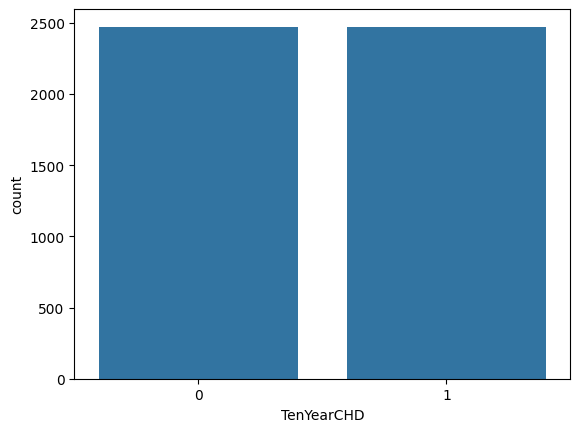

In [35]:
sns.countplot(x='TenYearCHD', data=training_data_smote)

<Axes: xlabel='TenYearCHD', ylabel='count'>

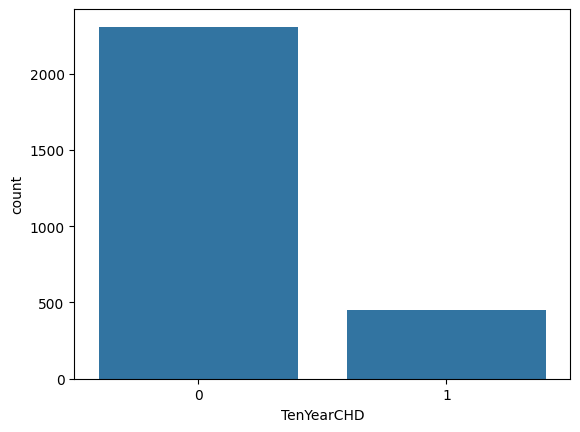

In [36]:
sns.countplot(x='TenYearCHD', data=training_data_tomek)

<Axes: xlabel='TenYearCHD', ylabel='count'>

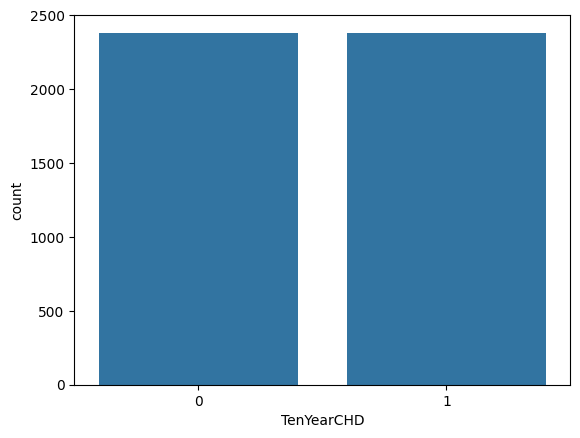

In [37]:
sns.countplot(x='TenYearCHD', data=training_data_smtom)

In [38]:
logistic_SMOTE = linear_model.LogisticRegression()
logistic_SMOTE.fit(X_train_smote, y_train_smote)
predictions_smote = logistic_SMOTE.predict(X_test)
accuracy_smote = (predictions_smote == y_test).sum() / len(y_test)
f1_smote = metrics.f1_score(y_true=y_test, y_pred=predictions_smote)
print(f"The accuracy is {100 * accuracy_smote:.2f}%.")
print(f"the f1 score is {f1_smote}")

The accuracy is 69.81%.
the f1 score is 0.39118457300275483


In [39]:
logistic_Tomek = linear_model.LogisticRegression()
logistic_Tomek.fit(X_train_tomek, y_train_tomek)
predictions_tomek = logistic_Tomek.predict(X_test)
accuracy_tomek = (predictions_tomek == y_test).sum() / len(y_test)
f1_tomek = metrics.f1_score(y_true=y_test, y_pred=predictions_tomek)
print(f"The accuracy is {100 * accuracy_tomek:.2f}%.")
print(f"the f1 score is {f1_tomek}")

The accuracy is 85.52%.
the f1 score is 0.07017543859649122


In [40]:
logistic_SMOTETomek = linear_model.LogisticRegression()
logistic_SMOTETomek.fit(X_train_smtom, y_train_smtom)
predictions_smtom = logistic_SMOTETomek.predict(X_test)
accuracy_smtom = (predictions_smtom == y_test).sum() / len(y_test)
f1_smtom = metrics.f1_score(y_true=y_test, y_pred=predictions_smtom)
print(f"The accuracy is {100 * accuracy_smtom:.2f}%.")
print(f"the f1 score is {f1_smtom}")

The accuracy is 69.13%.
the f1 score is 0.3858695652173913


**Question 10:** What can you deduce from the previous results?
1) Under-sampling penalizes the accuracy because it throws away relevant data.
2) SMOTE struggles to create samples belonging to the minority class distribution.
3) Combining the two results in a clear improvement over the two techniques alone.
4) SMOTE results in heavy overfitting.

In [41]:
answers[10] = 2

**Question 11:** We have seen different solutions to combat class imbalance, some of which can be combined. Explain in a few words what your next step would be.

In [42]:
answers[11] = 'I would try to implement a decision tree for this dataset'